[115.85679142 152.26153716 178.87449059 162.93500815 107.02820697
 105.19141146 118.38288501 125.3769803  102.88054011 206.71326136] ...


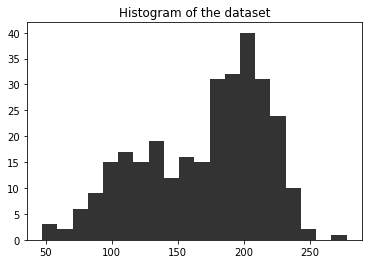

In [2]:
import pymc3 as pm
import theano
import numpy as np
import matplotlib.pyplot as plt

data = np.loadtxt('data/mixture_data.csv')

fig, ax = plt.subplots()
ax.hist(data, bins=20, color="k", histtype="stepfilled", alpha=0.8)
ax.set_title("Histogram of the dataset")
ax.set_ylim([0, None]);
print(data[:10], "...")

I will generate some synthetic data that looks like this data, but for which we know the actual cluster assignments.


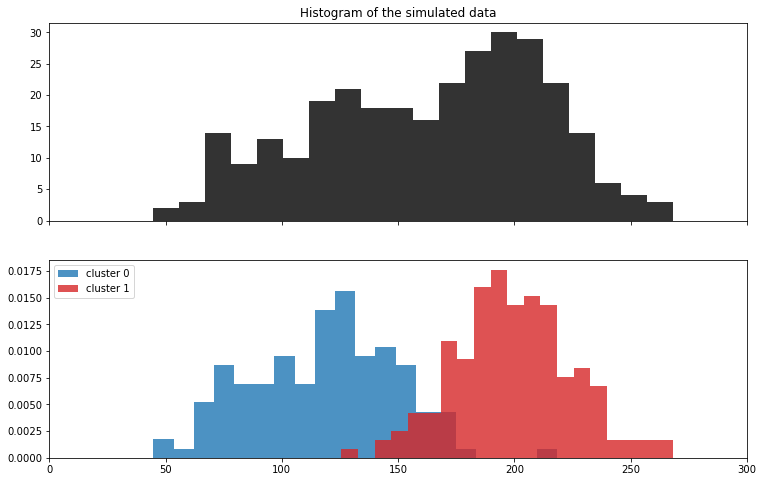

In [45]:
mu = [120.0, 200.0]
sig = [30.0, 22.0]
p = 0.4  # prob of being cluster 0

# i indexes the data observations
assignments = np.random.choice(a=[0, 1], p=[p, 1-p], size=300)  # assignments
mu_i = [ mu[z] for z in assignments ]
sig_i = [ sig[z] for z in assignments ]

data = [ np.random.normal(loc=mu[z], scale=sig[z]) for z in assignments ]

fig, ax = plt.subplots(nrows=2, figsize=(12.5, 8), sharex=True)
ax[0].hist(data, bins=20, color='k', histtype='stepfilled', alpha=0.8)
ax[0].set(title='Histogram of the simulated data', ylim=[0, None], xlim=[0, 300])

ax[1].hist(
    [data[j] for j in range(len(data)) if assignments[j] == 0],
    bins=20,
    color='tab:blue',
    histtype='stepfilled',
    alpha=0.8,
    density=True,
    label='cluster 0'
    )
ax[1].hist(
    [data[j] for j in range(len(data)) if assignments[j] == 1],
    bins=20,
    color='tab:red',
    histtype='stepfilled',
    alpha=0.8,
    density=True,
    label='cluster 1'
    )
ax[1].legend()

plt.show()

The first model will ignore all data about the actual labels. This is the model from the chapter.

In [64]:
with pm.Model() as model:
    p1 = pm.Uniform('p1', 0, 1)
    p2 = pm.Deterministic('p2', 1 - p1)
    p = theano.tensor.stack([p1, p2])
    # assignment variable
    z = pm.Categorical(
        'z',
        p,
        shape=data.shape[0],
        testval=np.random.randint(0, 2, data.shape[0]),
        )

    # (2) normal component parameters
    # These are the priors
    means = pm.Normal('means',
        mu=np.array([120, 190]),
        sd=np.array([10, 10]),
        shape=2,
    )
    stds = pm.Uniform('stds', 0, 50, shape=2)

    # latent observations
    # each mean_i (i=1,...,300) is either mu_1 or mu_2
    mean_i = pm.Deterministic('mean_i', means[z])
    # each std_i (i=1,...,300) is are either sig_1 or sig_2
    std_i = pm.Deterministic('std_i', stds[z])

    # likelihood
    obs = pm.Normal('obs', mu=mean_i, sd=std_i, observed=data)

In [66]:
with model:
    step1 = pm.Metropolis(vars=[p, stds, means])
    # step2 = pm.ElemwiseCategorical(vars=[z])
    step2 = pm.CategoricalGibbsMetropolis(vars=[z])
    trace = pm.sample(12_000, step=[step1, step2], return_inferencedata=False)

Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [means]
>>Metropolis: [stds]
>>Metropolis: [p1]
>CategoricalGibbsMetropolis: [z]


Sampling 2 chains for 1_000 tune and 12_000 draw iterations (2_000 + 24_000 draws total) took 760 seconds.
/home/DKS0559531/anaconda3/envs/pymc3_env/lib/python3.10/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The estimated number of effective samples is smaller than 200 for some parameters.


Let's visualize the traces of the parameters. Note that we will not show the traces for the assignments $z_i$ here.

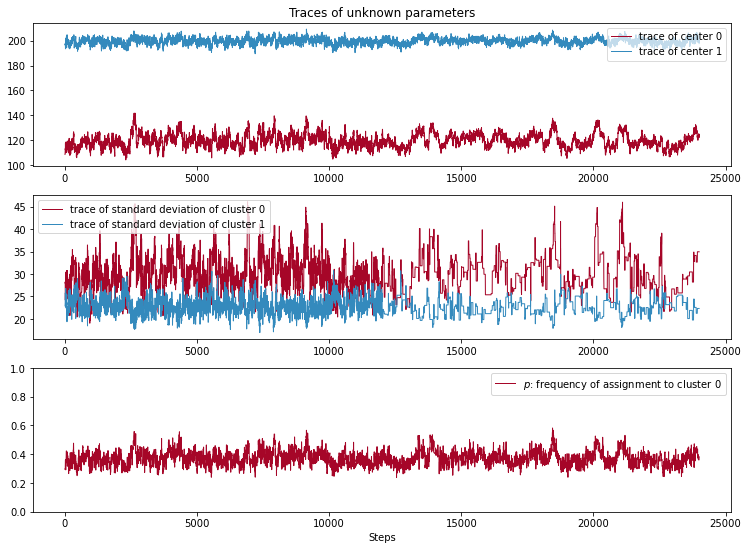

In [67]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=3, figsize=(12.5,9))
lw = 1
center_trace = trace["means"]

# for pretty colors later in the book.
colors = ["#348ABD", "#A60628"] if center_trace[-1, 0] > center_trace[-1, 1] \
    else ["#A60628", "#348ABD"]

ax[0].plot(center_trace[:, 0], label="trace of center 0", c=colors[0], lw=lw)
ax[0].plot(center_trace[:, 1], label="trace of center 1", c=colors[1], lw=lw)
ax[0].set_title("Traces of unknown parameters")
leg = ax[0].legend(loc="upper right")
leg.get_frame().set_alpha(0.7)

std_trace = trace["stds"]
ax[1].plot(std_trace[:, 0], label="trace of standard deviation of cluster 0",
     c=colors[0], lw=lw)
ax[1].plot(std_trace[:, 1], label="trace of standard deviation of cluster 1",
     c=colors[1], lw=lw)
ax[1].legend(loc="upper left")


p_trace = trace["p1"]
ax[2].plot(p_trace, label="$p$: frequency of assignment to cluster 0",
     color=colors[0], lw=lw)
ax[2].set(xlabel="Steps", ylim=[0, 1])
ax[2].legend();

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 array([118.38483845, 118.43483845, 118.48483845, 118.53483845,
        118.58483845, 118.63483845, 118.68483845, 118.73483845,
        118.78483845, 118.83483845, 118.88483845, 118.93483845,
        118.98483845, 119.03483845, 119.08483845, 119.13483845,
        119.18483845, 119.23483845, 119.28483845, 119.33483845,
        119.38483845]),
 <BarContainer object of 20 artists>)

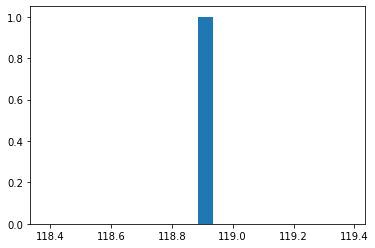

In [72]:
plt.hist(trace['means'][:4_000, 0].mean(), bins=20)

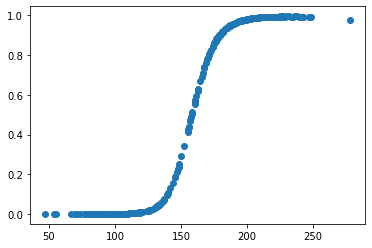

In [83]:
plt.scatter(data, trace['z'].mean(axis=0))